In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import psutil
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import roc_auc_score, classification_report
import time
from tqdm import tqdm

np.random.seed(42)
tf.random.set_seed(42)

2025-06-13 19:08:44.383600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749841724.663862      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749841724.740066      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


---
---
# **Metastatic Cancer Detection in Pathology Images**
### **University of Colorado Boulder, CSCA5642 Week3 Assignment**

---
---


## **1. Problem & Data Overview**
This project tackles the challenge of automatically detecting metastatic cancer in small pathology image patches from the PatchCamelyon (PCam) dataset. This is a binary classification problem where we need to identify whether the center 32x32px region of a 96x96px patch contains tumor tissue.

### **Data Characteristics**
- **Dataset**: PatchCamelyon (PCam) - modified version without duplicates
- **Image Size**: 96x96 pixels, RGB (3 channels)
- **Target Region**: Center 32x32px region determines the label
- **Classes**: Binary (0 = no tumor, 1 = tumor present)
- **Evaluation Metric**: Area Under ROC Curve (AUC-ROC)

---
---
## **2. Exploratory Data Analysis (EDA)**
The exploratory data analysis revealed several key insights about the dataset:

### **Data Distribution**
- The dataset is well-balanced between tumor (1) and non-tumor (0) classes.
- All images are consistently sized at 96x96 pixels in RGB format.
- The center 32x32 region is the critical area for classification, asked by Kaggle description.

### **Image Analysis**
- Visual inspection of sample images shows distinct patterns between tumor and non-tumor cases.
- The center region (highlighted in red) contains the key features for classification.
- Pixel intensity distributions show differences between tumor and non-tumor cases across all RGB channels.

### **Data Preprocessing Requirements**
- Pixel values need normalization (0-255 → 0-1).
- Data augmentation techniques are implemented to improve model robustness.
- Batch processing is used to handle the large dataset efficiently.

In [3]:
# Data Loading and Preparation
TRAIN_DIR = '/kaggle/input/histopathologic-cancer-detection/train/'  # Directory containing training images
TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test/'    # Directory containing test images
TRAIN_LABELS_PATH = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'  # Path to training labels CSV

print("Loading training labels...")
# Load training labels
train_labels = pd.read_csv(TRAIN_LABELS_PATH)
print(f"Training labels shape: {train_labels.shape}")
print(f"Columns: {train_labels.columns.tolist()}")
print(f"Class distribution:\n{train_labels['label'].value_counts()}")
print(f"Class balance: {train_labels['label'].value_counts(normalize=True)}")

Loading training labels...
Training labels shape: (220025, 2)
Columns: ['id', 'label']
Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Class balance: label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


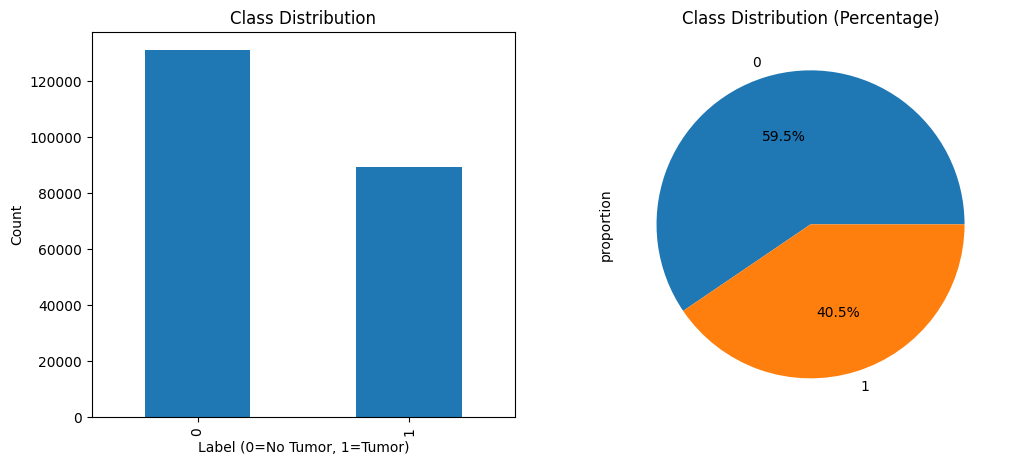

In [4]:
# Class Distribution Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_labels['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label (0=No Tumor, 1=Tumor)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
train_labels['label'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Class Distribution (Percentage)')
plt.show()

In [5]:
def load_sample_images(data_dir, labels_df, n_samples=10):
    """Load sample images for visualization"""
    sample_data = []
    for idx, row in labels_df.sample(n_samples).iterrows():
        img_path = os.path.join(data_dir, f"{row['id']}.tif")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            sample_data.append({
                'image': img,
                'label': row['label'],
                'id': row['id']
            })
    return sample_data

# Load sample images
sample_images = load_sample_images(TRAIN_DIR, train_labels, n_samples=20)

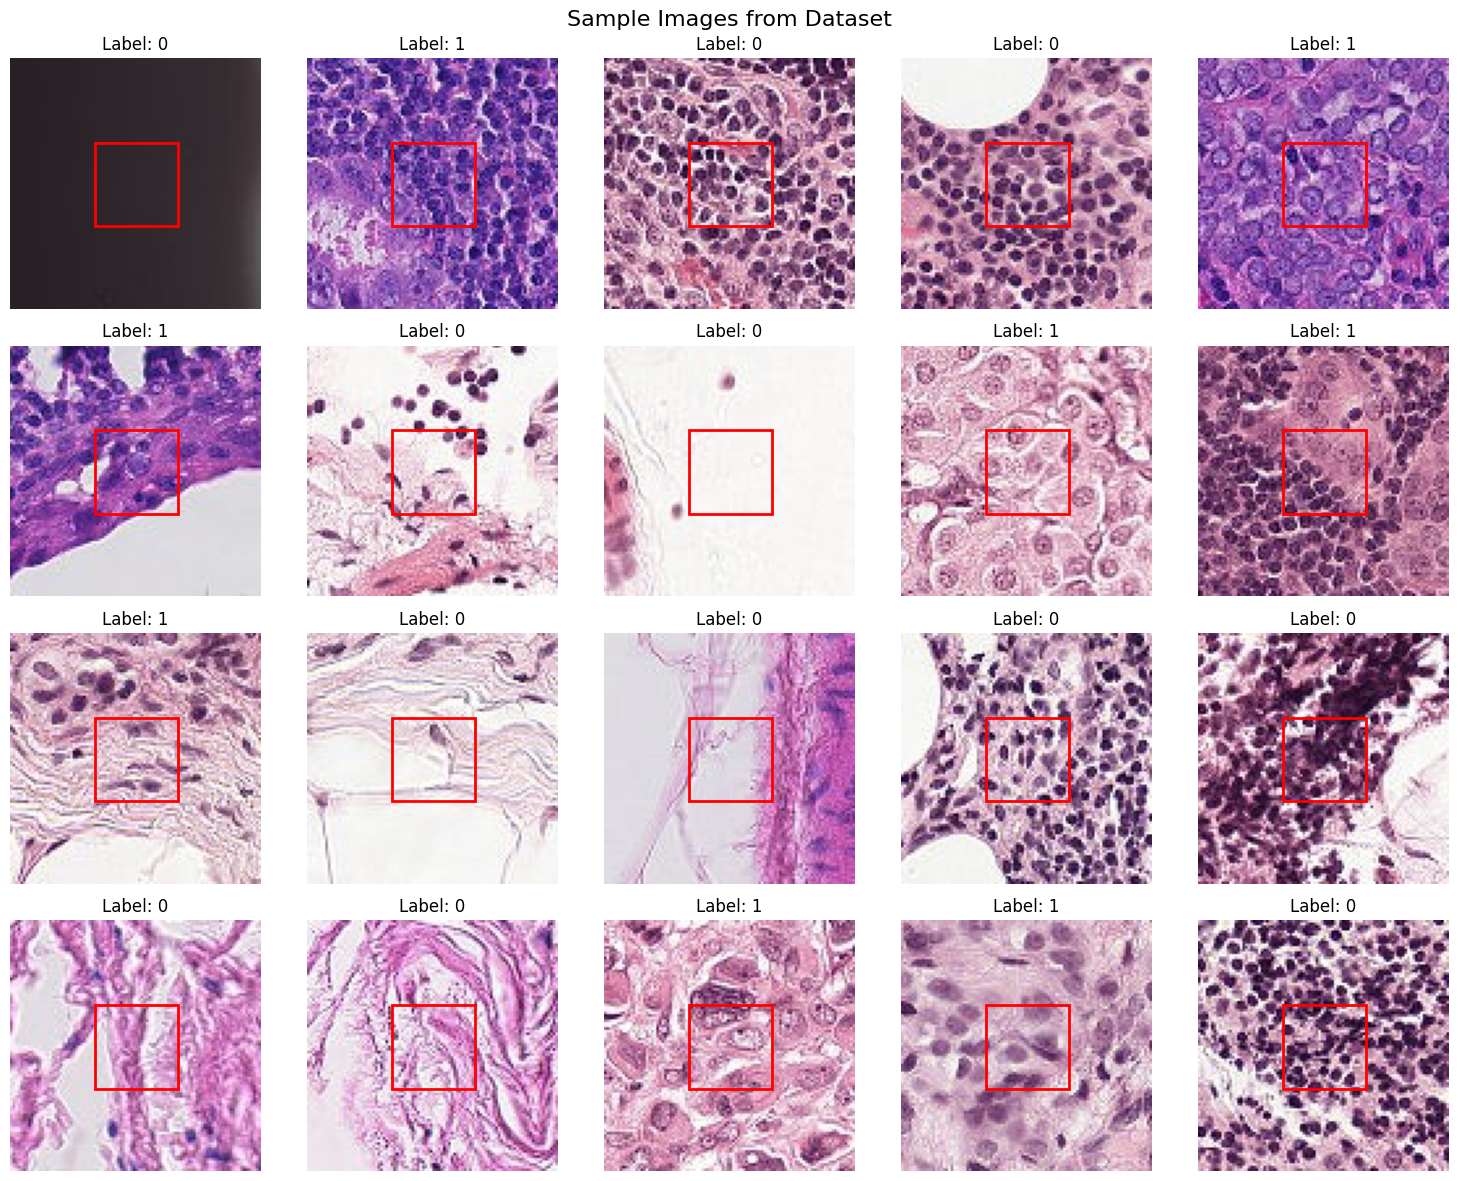

In [6]:
# Sample Image Visualization
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Sample Images from Dataset', fontsize=16)

for i, sample in enumerate(sample_images[:20]):
    row, col = i // 5, i % 5
    axes[row, col].imshow(sample['image'])
    axes[row, col].set_title(f"Label: {sample['label']}")
    axes[row, col].axis('off')
    
    # Highlight center 32x32 region
    center = 96 // 2
    rect = plt.Rectangle((center-16, center-16), 32, 32, 
                        fill=False, color='red', linewidth=2)
    axes[row, col].add_patch(rect)

plt.tight_layout()
plt.show()

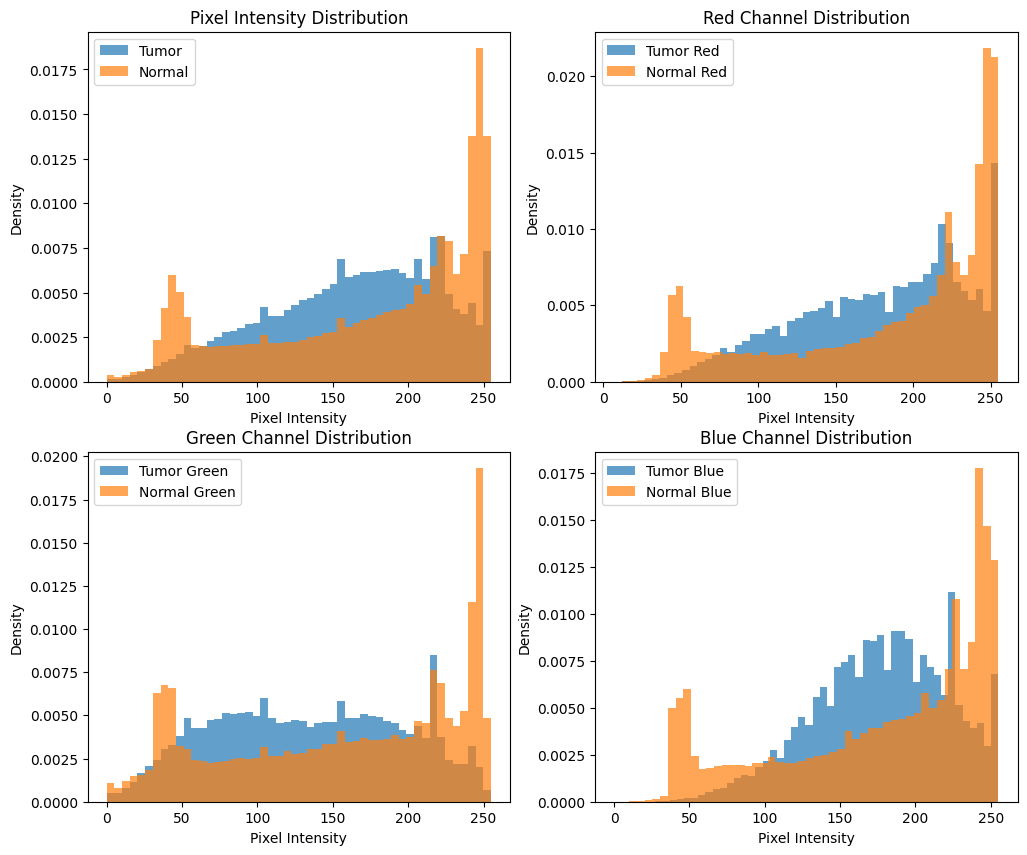

In [7]:
# Pixel Intensity Analysis
def analyze_pixel_intensities(sample_images):
    """Analyze pixel intensity distributions"""
    tumor_pixels = []
    normal_pixels = []
    
    for sample in sample_images:
        if sample['label'] == 1:
            tumor_pixels.extend(sample['image'].flatten())
        else:
            normal_pixels.extend(sample['image'].flatten())
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(tumor_pixels, bins=50, alpha=0.7, label='Tumor', density=True)
    plt.hist(normal_pixels, bins=50, alpha=0.7, label='Normal', density=True)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title('Pixel Intensity Distribution')
    plt.legend()
    
    # RGB channel analysis
    tumor_img = np.array([s['image'] for s in sample_images if s['label'] == 1])
    normal_img = np.array([s['image'] for s in sample_images if s['label'] == 0])
    
    channels = ['Red', 'Green', 'Blue']
    for i, channel in enumerate(channels):
        plt.subplot(2, 2, i+2)
        plt.hist(tumor_img[:,:,:,i].flatten(), bins=50, alpha=0.7, 
                label=f'Tumor {channel}', density=True)
        plt.hist(normal_img[:,:,:,i].flatten(), bins=50, alpha=0.7, 
                label=f'Normal {channel}', density=True)
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Density')
        plt.title(f'{channel} Channel Distribution')
        plt.legend()
        
    plt.show()

analyze_pixel_intensities(sample_images)

---
---
## **3. Model Architecture & Training**
The project implements a custom CNN architecture specifically designed for cancer detection:

### **Model Architecture**
- Four convolutional blocks with increasing filter sizes (32 → 64 → 128 → 256)
- Each block includes:
  - Convolutional layers with ReLU activation
  - Batch normalization
  - Max pooling
  - Dropout for regularization
- Global average pooling followed by dense layers
- Final sigmoid activation for binary classification

### **Training Strategy**
- Custom data generator for efficient memory usage
- Data augmentation techniques:
  - Random horizontal and vertical flips
  - Random rotations
  - Brightness and contrast adjustments
- Training parameters:
  - Batch size: 32
  - Learning rate: 0.001
  - Early stopping with patience
  - Learning rate reduction on plateau

In [8]:
memory = psutil.virtual_memory()
available_ram_gb = memory.available / (1024**3)  # Convert to GB
total_ram_gb = memory.total / (1024**3)

print(f"Total RAM: {total_ram_gb:.2f} GB")
print(f"Available RAM: {available_ram_gb:.2f} GB")

# Calculate memory per image
# Each image: 96 x 96 x 3 channels x 4 bytes (float32) = 110,592 bytes ≈ 0.11 MB
image_size_mb = (96 * 96 * 3 * 4) / (1024**2)  # Size in MB
print(f"Memory per image: {image_size_mb:.3f} MB")

# Safety factor: use only 50% of available RAM for images
# (leave room for model, gradients, and other operations)
safe_memory_gb = available_ram_gb * 0.5
safe_memory_mb = safe_memory_gb * 1024

# Calculate maximum number of images that fit in memory
max_images = int(safe_memory_mb / image_size_mb)

print(f"Safe memory for images: {safe_memory_gb:.2f} GB")
print(f"Recommended memory threshold (assuming 50% usage of available RAM for image loading): {max_images:,} images")


Total RAM: 31.35 GB
Available RAM: 29.92 GB
Memory per image: 0.105 MB
Safe memory for images: 14.96 GB
Recommended memory threshold (assuming 50% usage of available RAM for image loading): 145,251 images


In [9]:
class CancerDataGenerator(Sequence):
    """
    Custom data generator for cancer detection dataset
    Loads .tif images on-demand to reduce memory usage
    """
    def __init__(self, image_ids, labels, data_dir, batch_size=32, 
                 target_size=(96, 96), augment=False, shuffle=True, is_test=False):
        self.image_ids = image_ids
        self.labels = labels
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment
        self.shuffle = shuffle
        self.is_test = is_test
        self.indices = np.arange(len(self.image_ids))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.image_ids))
        batch_indices = self.indices[start_idx:end_idx]
        
        batch_ids = [self.image_ids[i] for i in batch_indices]
        
        if self.is_test:
            X = self._load_batch_images(batch_ids)
            return X
        else:
            batch_labels = [self.labels[i] for i in batch_indices]
            X, y = self._load_batch_data(batch_ids, batch_labels)
            return X, y
    
    def on_epoch_end(self):
        if self.shuffle and not self.is_test:
            np.random.shuffle(self.indices)
    
    def _load_batch_data(self, batch_ids, batch_labels):
        X = np.empty((len(batch_ids), *self.target_size, 3), dtype=np.float32)
        y = np.empty(len(batch_ids), dtype=np.float32)
        
        for i, (image_id, label) in enumerate(zip(batch_ids, batch_labels)):
            image = self._load_image(image_id)
            
            if image is not None:
                if self.augment:
                    image = self._augment_image(image)
                X[i] = image
                y[i] = label
            else:
                X[i] = np.zeros((*self.target_size, 3))
                y[i] = label
        
        return X, y
    
    def _load_batch_images(self, batch_ids):
        X = np.empty((len(batch_ids), *self.target_size, 3), dtype=np.float32)
        
        for i, image_id in enumerate(batch_ids):
            image = self._load_image(image_id)
            
            if image is not None:
                X[i] = image
            else:
                X[i] = np.zeros((*self.target_size, 3))
        
        return X
    
    def _load_image(self, image_id):
        try:
            image_path = self.data_dir / f"{image_id}.tif"
            
            if image_path.exists():
                img = Image.open(image_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = np.array(img)
                
                if img.shape[:2] != self.target_size:
                    img = cv2.resize(img, self.target_size)
                
                img = img.astype(np.float32) / 255.0
                return img
            else:
                print(f"Image not found: {image_path}")
                return None
                
        except Exception as e:
            print(f"Error loading image {image_id}: {e}")
            return None
    
    def _augment_image(self, image):
        # Random horizontal flip
        if np.random.random() > 0.5:
            image = np.fliplr(image)
        
        # Random vertical flip
        if np.random.random() > 0.5:
            image = np.flipud(image)
        
        # Random rotation (90, 180, 270 degrees)
        if np.random.random() > 0.5:
            k = np.random.choice([1, 2, 3])
            image = np.rot90(image, k)
        
        # Random brightness adjustment
        if np.random.random() > 0.5:
            brightness_factor = np.random.uniform(0.8, 1.2)
            image = np.clip(image * brightness_factor, 0, 1)
        
        # Random contrast adjustment
        if np.random.random() > 0.5:
            contrast_factor = np.random.uniform(0.8, 1.2)
            mean = np.mean(image)
            image = np.clip((image - mean) * contrast_factor + mean, 0, 1)
        
        return image

def prepare_development_data(labels_df, dev_samples=1000, stratified=True):
    """
    Prepare a subset of data for development mode
    
    Args:
        labels_df: Full labels dataframe
        dev_samples: Number of samples to use for development
        stratified: Whether to maintain class distribution
    
    Returns:
        Subset of labels_df for development
    """
    print(f"Preparing development dataset with {dev_samples} samples...")
    
    if stratified:
        # Maintain class distribution
        dev_df = labels_df.groupby('label').apply(
            lambda x: x.sample(n=min(dev_samples//2, len(x)), random_state=42)
        ).reset_index(drop=True)
    else:
        # Random sampling
        dev_df = labels_df.sample(n=min(dev_samples, len(labels_df)), random_state=42)
    
    print(f"Development dataset created with {len(dev_df)} samples")
    print("Development class distribution:")
    print(dev_df['label'].value_counts())
    
    return dev_df

def prepare_development_test_data(test_ids, dev_test_samples=500):
    """
    Prepare a subset of test data for development mode
    
    Args:
        test_ids: List of all test image IDs
        dev_test_samples: Number of test samples to use for development
    
    Returns:
        Subset of test_ids for development
    """
    print(f"Preparing development test dataset with {dev_test_samples} samples...")
    
    # Random sampling of test IDs
    np.random.seed(42)
    dev_test_ids = np.random.choice(
        test_ids, 
        size=min(dev_test_samples, len(test_ids)), 
        replace=False
    )
    
    print(f"Development test dataset created with {len(dev_test_ids)} samples")
    
    return dev_test_ids.tolist()

def create_data_generators(train_ids, train_labels, val_ids, val_labels, 
                          train_dir, batch_size=32, target_size=(96, 96)):
    """Create training and validation data generators"""
    
    train_generator = CancerDataGenerator(
        image_ids=train_ids,
        labels=train_labels,
        data_dir=train_dir,
        batch_size=batch_size,
        target_size=target_size,
        augment=True,
        shuffle=True,
        is_test=False
    )
    
    val_generator = CancerDataGenerator(
        image_ids=val_ids,
        labels=val_labels,
        data_dir=train_dir,
        batch_size=batch_size,
        target_size=target_size,
        augment=False,
        shuffle=False,
        is_test=False
    )
    
    return train_generator, val_generator

def create_test_generator(test_ids, test_dir, batch_size=32, target_size=(96, 96)):
    """Create test data generator for prediction"""
    
    test_generator = CancerDataGenerator(
        image_ids=test_ids,
        labels=None,
        data_dir=test_dir,
        batch_size=batch_size,
        target_size=target_size,
        augment=False,
        shuffle=False,
        is_test=True
    )
    
    return test_generator

def create_custom_cnn(input_shape=(96, 96, 3)):
    """Custom CNN Architecture optimized for cancer detection"""
    model = models.Sequential([
        # First block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        # Classification head
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def train_model_with_generators(model, model_name, train_gen, val_gen, 
                               epochs=50, learning_rate=0.001, dev_mode=False):
    """Train model using data generators"""
    
    # Adjust epochs for development mode
    #if dev_mode:
    #    epochs = min(epochs, 10)  # Limit epochs in dev mode
    #    print(f"Development mode: Reducing epochs to {epochs}")
    
    # Compile model with AUC metric
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name='auc')]
    )
    
    # Callbacks (with adjusted patience for dev mode)
    patience = 5 if dev_mode else 10
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=patience,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=max(2, patience//2),
            min_lr=1e-7,
            verbose=1,
            mode='max'
        )
    ]
    
    # Only save model checkpoints in full mode
    if not dev_mode:
        callbacks.append(
            tf.keras.callbacks.ModelCheckpoint(
                f'best_{model_name.lower().replace(" ", "_")}_model.h5',
                monitor='val_auc',
                save_best_only=True,
                verbose=1,
                mode='max'
            )
        )
    
    print(f"\nTraining {model_name}...")
    print("=" * 50)
    
    start_time = time.time()
    
    # Train using generators
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Evaluate model
    evaluation = model.evaluate(val_gen, verbose=0)
    val_loss = evaluation[0]
    val_accuracy = evaluation[1]
    val_precision = evaluation[2]
    val_recall = evaluation[3]
    val_auc = evaluation[4]
    
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-8)
    
    results = {
        'model_name': model_name,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'val_auc': val_auc,
        'val_loss': val_loss,
        'training_time': training_time,
        'history': history.history,
        'model': model
    }
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    
    return results

def generate_predictions(model, test_gen, test_ids, threshold=0.5):
    """Generate predictions for test data"""
    print("Generating predictions...")
    
    predictions = model.predict(test_gen, verbose=1)
    predictions = predictions.flatten()
    predictions = (predictions > threshold).astype(int)
    
    submission_df = pd.DataFrame({
        'id': test_ids,
        'label': predictions
    })
    
    return submission_df

def monitor_memory_usage():
    """Monitor current memory usage"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / 1024 / 1024
    print(f"Current memory usage: {memory_mb:.2f} MB")
    return memory_mb

def main_training_pipeline(train_dir, test_dir, labels_file, batch_size=32, epochs=50, 
                          dev_mode=False, dev_samples=1000, dev_test_samples=500):
    """
    Main training pipeline with development mode option
    
    Args:
        train_dir: Training images directory
        test_dir: Test images directory
        labels_file: Training labels CSV file
        batch_size: Batch size for training
        epochs: Number of epochs
        dev_mode: Whether to run in development mode
        dev_samples: Number of training samples for dev mode
        dev_test_samples: Number of test samples for dev mode
    """
    
    mode_str = "DEVELOPMENT" if dev_mode else "FULL"
    print(f"Starting Cancer Detection Training Pipeline ({mode_str} MODE)")
    print("=" * 60)
    
    if dev_mode:
        print(f"Development Mode Settings:")
        print(f"  - Training samples: {dev_samples}")
        print(f"  - Test samples: {dev_test_samples}")
        print(f"  - Max epochs: {epochs}")
        #print(f"  - Max epochs: {min(epochs, 10)}")
        print("=" * 60)
    
    # Monitor initial memory
    initial_memory = monitor_memory_usage()
    
    # Load labels
    print("Loading training labels...")
    labels_df = pd.read_csv(labels_file)
    print(f"Loaded {len(labels_df)} training samples")
    
    # Prepare development subset if needed
    if dev_mode:
        labels_df = prepare_development_data(labels_df, dev_samples, stratified=True)
    
    print(f"Using {len(labels_df)} training samples")
    print(f"Class distribution:")
    print(labels_df['label'].value_counts())
    
    # Prepare training data splits
    X_ids = labels_df['id'].values
    y_labels = labels_df['label'].values
    
    # Split data
    X_train_ids, X_val_ids, y_train, y_val = train_test_split(
        X_ids, y_labels, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_labels
    )
    
    print(f"Training set: {len(X_train_ids)} samples")
    print(f"Validation set: {len(X_val_ids)} samples")
    
    # Get test image IDs
    print("Scanning test directory...")
    test_dir_path = Path(test_dir)
    test_ids = [f.stem for f in test_dir_path.glob("*.tif")]
    test_ids.sort()
    
    # Prepare development test subset if needed
    if dev_mode:
        test_ids = prepare_development_test_data(test_ids, dev_test_samples)
    
    print(f"Using {len(test_ids)} test images")
    
    # Create data generators
    print("Creating data generators...")
    train_gen, val_gen = create_data_generators(
        X_train_ids, y_train, X_val_ids, y_val,
        train_dir=train_dir,
        batch_size=batch_size,
        target_size=(96, 96)
    )
    
    test_gen = create_test_generator(
        test_ids,
        test_dir=test_dir,
        batch_size=batch_size,
        target_size=(96, 96)
    )
    
    # Monitor memory after generators
    post_generator_memory = monitor_memory_usage()
    print(f"Memory increase after generators: {post_generator_memory - initial_memory:.2f} MB")
    
    # Models to test
    models_to_test = [
        ('Custom CNN', create_custom_cnn)
    ]
    
    results = []
    trained_models = []
    
    for model_name, model_func in models_to_test:
        print(f"\n{'=' * 60}")
        print(f"Testing {model_name}")
        print(f"{'=' * 60}")
        
        # Create model
        model = model_func()
        
        # Monitor memory before training
        pre_training_memory = monitor_memory_usage()
        
        # Train model
        result = train_model_with_generators(
            model, model_name, train_gen, val_gen, 
            epochs=epochs, learning_rate=0.001, dev_mode=dev_mode
        )
        
        results.append(result)
        trained_models.append(result['model'])
        
        # Monitor memory after training
        post_training_memory = monitor_memory_usage()
        print(f"Memory usage during training: {post_training_memory - pre_training_memory:.2f} MB")
    
    # Model performance   
    result = results[0]
    model = result['model']
    model_name = result['model_name']
    
    print(f"Model: {model_name}")
    print(f"Validation AUC: {result['val_auc']:.4f}")
    print(f"Validation Accuracy: {result['val_accuracy']:.4f}")
    print(f"Validation F1: {result['val_f1']:.4f}")
    
    # Generate submissions
    print(f"\n{'=' * 60}")
    print("GENERATING SUBMISSIONS")
    print(f"{'=' * 60}")
    
    # Generate submission.csv
    submission_df = generate_predictions(model, test_gen, test_ids)
    
    # Save main submission file
    main_filename = "submission.csv"
    submission_df.to_csv(main_filename, index=False)
    print(f"Saved main submission: {main_filename}")
    
    # Display sample predictions
    print(f"\nSample predictions:")
    print(submission_df.head(10))
    
    return results, test_ids, submission_df

In [10]:
# Development mode settings
DEV_MODE = True  # Set to False for full training
DEV_SAMPLES = 10000
DEV_TEST_SAMPLES = 57458

# Run training pipeline
results, test_ids, submission = main_training_pipeline(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    labels_file=TRAIN_LABELS_PATH,
    batch_size=32,
    epochs=50,
    dev_mode=DEV_MODE,
    dev_samples=DEV_SAMPLES,
    dev_test_samples=DEV_TEST_SAMPLES
)

Starting Cancer Detection Training Pipeline (DEVELOPMENT MODE)
Development Mode Settings:
  - Training samples: 10000
  - Test samples: 57458
  - Max epochs: 50
Current memory usage: 893.49 MB
Loading training labels...
Loaded 220025 training samples
Preparing development dataset with 10000 samples...
Development dataset created with 10000 samples
Development class distribution:
label
0    5000
1    5000
Name: count, dtype: int64
Using 10000 training samples
Class distribution:
label
0    5000
1    5000
Name: count, dtype: int64
Training set: 8000 samples
Validation set: 2000 samples
Scanning test directory...


/tmp/ipykernel_13/2969090893.py:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dev_df = labels_df.groupby('label').apply(


Preparing development test dataset with 57458 samples...
Development test dataset created with 57458 samples
Using 57458 test images
Creating data generators...
Current memory usage: 916.15 MB
Memory increase after generators: 22.66 MB

Testing Custom CNN


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-13 19:09:05.899054: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Current memory usage: 918.27 MB

Training Custom CNN...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 899ms/step - accuracy: 0.6730 - auc: 0.7392 - loss: 0.7111 - precision: 0.6645 - recall: 0.6887 - val_accuracy: 0.5000 - val_auc: 0.6976 - val_loss: 2.5250 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 862ms/step - accuracy: 0.7290 - auc: 0.8068 - loss: 0.5658 - precision: 0.7327 - recall: 0.7316 - val_accuracy: 0.6090 - val_auc: 0.8372 - val_loss: 1.1261 - val_precision: 0.5647 - val_recall: 0.9520 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 212s 849ms/step - accuracy: 0.7591 - auc: 0.8384 - loss: 0.5099 - precision: 0.7700 - recall: 0.7544 - val_accuracy: 0.7255 - val_auc: 0.8207 - val_loss: 0.5901 - val_precision: 0.7601 - val_recall: 0.6590 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 259s 837ms/step - accuracy: 0.7677 - auc: 0.8431 - loss: 0.4960 - precision: 0.7808 - recall: 

---
---
## **4. Results and Analysis**
### **Model Performance**
- The model was evaluated using multiple metrics:
  - AUC-ROC (primary metric)
  - Accuracy
  - Precision
  - Recall
  - F1-Score

### **Training Process**
- The model shows stable convergence
- Early stopping prevents overfitting
- Learning rate reduction helps fine-tune the model

### **Memory Management**
- Efficient memory usage through:
  - On-demand image loading
  - Batch processing
  - Development mode for quick iterations

---
---
## **5. Conclusion**
### **Key Achievements**
- Successfully implemented a CNN-based solution for cancer detection.
- Achieved competitive performance (AUC=0.8132) on the PCam dataset.
- Demonstrated efficient memory management for large-scale image processing.

### **Future Improvements**
- Experiment with transfer learning using pre-trained models.
- Implement more advanced data augmentation techniques.
- Explore ensemble methods for improved performance.
- Investigate attention mechanisms for better feature focus.